In [13]:
import pandas as pd
import os

In [256]:
import random
import matplotlib.pyplot as plt
import collections
import numpy as np
import operator
import simpleclock
import sklearn.metrics
import itertools
import pickle

In [15]:
import torch
import torchtext

## Dataset, iterators

In [16]:
data_path = os.path.join(os.path.abspath(''), "data_cine_cleaned.csv")

In [17]:
TEXT = torchtext.data.Field(tokenize = "spacy",
                            tokenizer_language="fr_core_news_sm",
                            include_lengths=True)
LABEL = torchtext.data.LabelField(dtype=torch.float, use_vocab=False)

In [18]:
dataset = torchtext.data.TabularDataset(path=data_path,
                                        format="CSV",
                                        fields={"critique": ("critique", TEXT), "note": ("note", LABEL)})

In [19]:
data_train, data_test = dataset.split()

In [20]:
data_train, data_valid = data_train.split()

In [21]:
print(f"""training data: {len(data_train)} examples.
validation data: {len(data_valid)} examples.
test data: {len(data_test)} examples.""")

training data: 36057 examples.
validation data: 15453 examples.
test data: 22076 examples.


In [22]:
vectors = torchtext.vocab.Vectors("cc.fr.300.vec", os.path.join(os.path.expanduser("~"), "Downloads"))

In [23]:
VOCAB_MAX_SIZE = 50000
TEXT.build_vocab(data_train, max_size=VOCAB_MAX_SIZE, vectors=vectors)

In [62]:
DEVICE = torch.device("cuda")

In [25]:
BATCH_SIZE = 256

In [26]:
iter_train, iter_valid, iter_test = \
    torchtext.data.BucketIterator.splits(datasets=(data_train, data_valid, data_test),
                                         batch_size=BATCH_SIZE,
                                         device=device,
                                         sort_within_batch=True,
                                         sort_key=lambda example: len(example.critique),
                                         sort=False)

## Model definition and training

In [250]:
class RNN(torch.nn.Module):
    def __init__(self, n_vocab, embedding_dim, hidden_dim, output_dim, dropout, bidirectional,
                 n_layers, pad_idx):
        super().__init__()
        self.bidirectional = bidirectional
        num_dir = 2 if bidirectional else 1
        self.embedding = torch.nn.Embedding(n_vocab, embedding_dim, padding_idx=pad_idx)
        self.rnn = torch.nn.LSTM(embedding_dim,
                                 hidden_dim,
                                 bidirectional=bidirectional,
                                 num_layers=n_layers)
        self.fc = torch.nn.Linear(hidden_dim * num_dir, output_dim)
        self.dropout = torch.nn.Dropout(dropout)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, input, lengths):
        torch.nn.utils.rnn.pack_padded_sequence(input, lengths)
        embedded = self.embedding(input)  # ((sent_len, batch), emb_dim)
        packed_output, (hidden, cell) = self.rnn(embedded)  # hidden: (num_layers * num_directions,
                                                            #          batch, hidden_size * num_directions)
        hidden = (torch.cat([hidden[-2, :, :], hidden[-1, :, :]], dim=1)
                  if self.bidirectional else hidden).squeeze(0)  # (batch, hidden_size * num_directions)
        return self.sigmoid(self.fc(self.dropout(hidden)))  # (batch, 1)

In [242]:
# N_VOCAB = len(TEXT.vocab)
# EMBEDDING_DIM = 300
# HIDDEN_DIM = 256
# OUTPUT_DIM = 1
# DROPOUT = 0.5
# BIDIRECTIONAL = True
# N_LAYERS = 1
# PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
# UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

# def default_model(
#     n_vocab=N_VOCAB,
#     embedding_dim=EMBEDDING_DIM,
#     hidden_dim=HIDDEN_DIM,
#     output_dim=OUTPUT_DIM,
#     dropout=DROPOUT,
#     pad_idx=PAD_IDX,
#     bidirectional=BIDIRECTIONAL,
#     n_layers=N_LAYERS,
# ): 
#     return RNN(
#         n_vocab=n_vocab,
#         embedding_dim=embedding_dim,
#         hidden_dim=hidden_dim,
#         output_dim=output_dim,
#         dropout=dropout,
#         pad_idx=pad_idx,
#         bidirectional=bidirectional,
#         n_layers=n_layers,
#     )

In [251]:
# alternative
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

DEFAULT_PARAMS = {
    "n_vocab": len(TEXT.vocab),
    "embedding_dim": 300,
    "hidden_dim": 256,
    "output_dim": 1,
    "dropout": 0.5,
    "bidirectional": True,
    "n_layers": 1,
    "pad_idx": PAD_IDX,
}

def default_model(**kwargs):
    _d = {}
    _d.update(DEFAULT_PARAMS)
    _d.update(kwargs)
    return RNN(**_d)

In [241]:
def pseudo_init(model, criterion, device=device, learn_embedding_param=True):
    model.embedding.weight.data.copy_(TEXT.vocab.vectors)
    model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
    model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
    
    for name, param in model.named_parameters():
        if name == "embedding.weight":
            param.requires_grad = learn_embedding_param
    print("The model has {:,} trainable parameters"
         .format(sum(p.numel() for p in model.parameters() if p.requires_grad)))
    
    model = model.to(device)
    criterion = criterion.to(device)
    
    return model, criterion

In [30]:
# model, criterion = pseudo_init(model, torch.nn.MSELoss(), learn_embedding_param=False)
# optimizer = torch.optim.Adam(model.parameters())

In [31]:
def output_to_pred(output):
    return (output * 10).round() / 2

In [32]:
def accuracy(preds, y):
    correct = (preds == y).float()# convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [217]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        optimizer.zero_grad()
        padded_sequences, lengths = batch.critique
        output = model(padded_sequences, lengths).squeeze(1)
        loss = criterion(output, batch.note / 5.)
        acc = accuracy(output_to_pred(output), batch.note)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
      
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [218]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        for batch in iterator:
            padded_sequences, lengths = batch.critique
            output = model(padded_sequences, lengths).squeeze(1)
            loss = criterion(output, batch.note / 5.)
            acc = accuracy(output_to_pred(output), batch.note)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [195]:
class TrainInfo:
    def __init__(self, valid={}, train={}):
        self.valid = collections.defaultdict(lambda: [])
        self.valid.update(valid)
        self.train = collections.defaultdict(lambda: [])
        self.train.update(train)
    
    def save(self, path):
        packed = {
            "valid": dict(self.valid),
            "train": dict(self.train),
        }
        with open(path, "wb") as f:
            pickle.dump(packed, f)
    
    @classmethod
    def load(cls, path):
        with open(path, "rb") as f:
            packed = pickle.load(f)
            return cls(valid=packed["valid"],
                       train=packed["train"])
    
    @staticmethod
    def _dict_to_repr(d):
        return dict(map(lambda k_v: (k_v[0], f"{len(k_v[1])} elements"), d.items()))
    
    def __repr__(self):
        return pprint.pformat({"valid": self._dict_to_repr(self.valid),
                     "train": self._dict_to_repr(self.train),})

In [268]:
def do_training(model, name, iter_train, iter_valid, optimizer, criterion, fun_train,
                fun_eval, n_epochs=100, train_info=None):

    clock = simpleclock.Clock.started()
    torch.cuda.empty_cache()
    train_info = train_info if train_info is not None else TrainInfo()
    best_valid_loss = min(train_info.valid["loss"]) if train_info.valid["loss"] else float("inf")
    
    for epoch in range(n_epochs):

        clock.elapsed_since_start.call()  # meh

        train_loss, train_acc = fun_train(model, iter_train, optimizer, criterion)
        valid_loss, valid_acc = fun_eval(model, iter_valid, criterion)

        clock.elapsed_since_last_call.print(
            f"Epoch: {epoch+1:<3}. T, V acc: {100 * train_acc:.1f}%, {100 * valid_acc:.1f}%. Took")
        train_info.train["loss"].append(train_loss)
        train_info.valid["loss"].append(valid_loss)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), f"{name}.pt")

    clock.elapsed_since_start.print(f"Trained {name}, {n_epochs} epochs, for")
    return train_info

In [98]:
class TrainSet:
    def __init__(self, model, name, iter_train, iter_valid,
                 fun_optimizer, fun_criterion, fun_train, fun_eval,
                 device=DEVICE, n_epochs=100):
        self.model = model
        self.name = name
        self.iter_train = iter_train
        self.iter_valid = iter_valid
        self.fun_optimizer = fun_optimizer
        self.fun_criterion = fun_criterion
        self.fun_train = fun_train
        self.fun_eval = fun_eval
        self.n_epochs = n_epochs
        self.device = device
        
        self.optimizer = None
        self.criterion = None
        
    def init(self, learn_embedding_param=True):
        self.model, self.criterion = pseudo_init(self.model, self.fun_criterion(), self.device,
                                                 learn_embedding_param=learn_embedding_param)
        self.optimizer = self.fun_optimizer(self.model.parameters())
    
    def do_training(self):
        if self.optimizer is None or self.criterion is None:
            raise Exception("It looks like an init is needed: optimizer or criterion is None")
        return do_training(model=self.model,
                           name=self.name,
                           iter_train=self.iter_train,
                           iter_valid=self.iter_valid,
                           optimizer=self.optimizer,
                           criterion=self.criterion,
                           fun_train=self.fun_train,
                           fun_eval=self.fun_eval,
                           n_epochs=self.n_epochs)

In [269]:
train_sets = []

for hidden_dim, n_layers in itertools.product([128, 256], [1, 2, 3]):
    train_sets.append(TrainSet(
        model=default_model(hidden_dim=hidden_dim, n_layers=n_layers),
        name=f"rnn_hidden-{hidden_dim}_nlayers-{n_layers}",
        iter_train=iter_train,
        iter_valid=iter_valid,
        fun_optimizer=torch.optim.Adam,
        fun_criterion=torch.nn.MSELoss,
        fun_train=train,
        fun_eval=evaluate,
        n_epochs=200
    ))

The model has 15,441,177 trainable parameters
Epoch: 1  . T, V acc: 13.7%, 21.0%. Took: 2.70s
Epoch: 2  . T, V acc: 25.7%, 23.3%. Took: 2.60s
Epoch: 3  . T, V acc: 31.0%, 24.6%. Took: 2.63s
Epoch: 4  . T, V acc: 33.6%, 23.4%. Took: 2.63s
Epoch: 5  . T, V acc: 39.1%, 24.8%. Took: 2.57s
Epoch: 6  . T, V acc: 35.8%, 21.8%. Took: 2.58s
Epoch: 7  . T, V acc: 42.3%, 22.6%. Took: 2.59s
Epoch: 8  . T, V acc: 51.3%, 22.1%. Took: 2.57s
Epoch: 9  . T, V acc: 59.3%, 21.7%. Took: 2.65s
Epoch: 10 . T, V acc: 64.0%, 21.4%. Took: 2.66s
Epoch: 11 . T, V acc: 64.4%, 21.8%. Took: 2.68s
Epoch: 12 . T, V acc: 66.0%, 21.9%. Took: 2.60s
Epoch: 13 . T, V acc: 70.3%, 21.8%. Took: 2.57s
Epoch: 14 . T, V acc: 73.9%, 22.0%. Took: 2.62s
Epoch: 15 . T, V acc: 75.1%, 21.8%. Took: 2.64s
Epoch: 16 . T, V acc: 75.8%, 21.7%. Took: 2.63s
Epoch: 17 . T, V acc: 75.6%, 21.6%. Took: 2.64s
Epoch: 18 . T, V acc: 74.4%, 21.2%. Took: 2.64s
Epoch: 19 . T, V acc: 75.8%, 21.8%. Took: 2.62s
Epoch: 20 . T, V acc: 78.1%, 22.0%. Took: 

Epoch: 171. T, V acc: 99.3%, 25.6%. Took: 2.48s
Epoch: 172. T, V acc: 99.4%, 25.5%. Took: 2.95s
Epoch: 173. T, V acc: 99.4%, 26.0%. Took: 2.48s
Epoch: 174. T, V acc: 99.5%, 25.8%. Took: 2.48s
Epoch: 175. T, V acc: 99.6%, 25.4%. Took: 2.48s
Epoch: 176. T, V acc: 99.5%, 25.3%. Took: 2.49s
Epoch: 177. T, V acc: 99.4%, 25.6%. Took: 2.48s
Epoch: 178. T, V acc: 99.5%, 25.2%. Took: 2.50s
Epoch: 179. T, V acc: 99.4%, 25.4%. Took: 2.49s
Epoch: 180. T, V acc: 99.5%, 25.5%. Took: 2.49s
Epoch: 181. T, V acc: 99.4%, 25.4%. Took: 2.48s
Epoch: 182. T, V acc: 97.7%, 24.8%. Took: 2.60s
Epoch: 183. T, V acc: 98.3%, 25.1%. Took: 2.60s
Epoch: 184. T, V acc: 99.1%, 25.2%. Took: 2.61s
Epoch: 185. T, V acc: 99.3%, 25.4%. Took: 2.61s
Epoch: 186. T, V acc: 99.4%, 25.2%. Took: 2.61s
Epoch: 187. T, V acc: 99.4%, 25.5%. Took: 2.60s
Epoch: 188. T, V acc: 97.7%, 24.9%. Took: 2.60s
Epoch: 189. T, V acc: 98.7%, 25.6%. Took: 2.60s
Epoch: 190. T, V acc: 99.3%, 25.2%. Took: 2.61s
Epoch: 191. T, V acc: 99.5%, 25.3%. Took

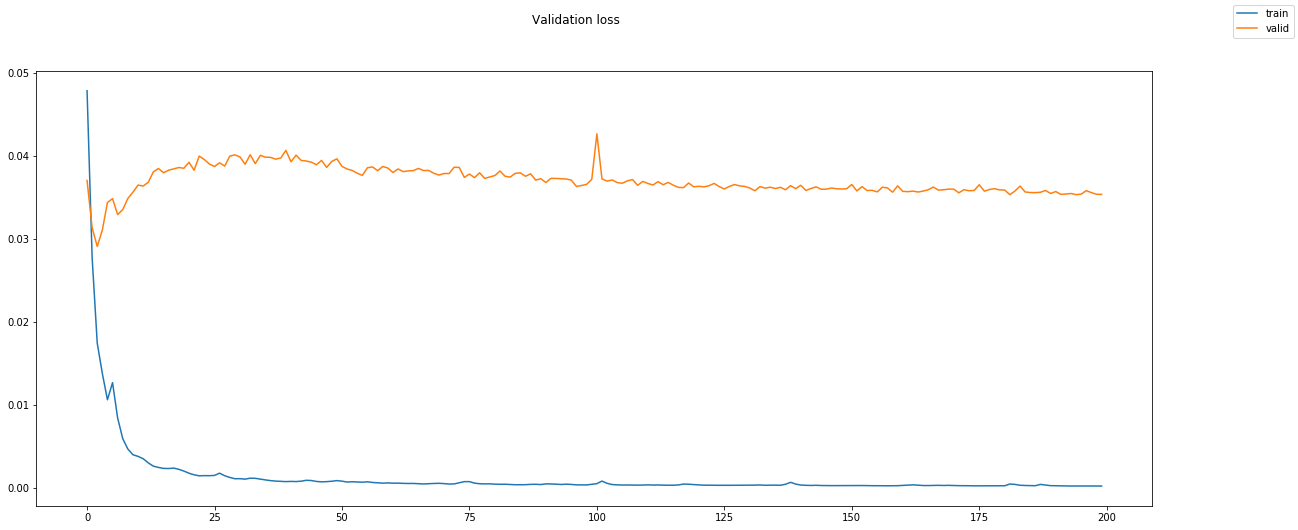

The model has 15,836,441 trainable parameters
Epoch: 1  . T, V acc: 13.7%, 18.4%. Took: 3.66s
Epoch: 2  . T, V acc: 25.6%, 25.8%. Took: 3.66s
Epoch: 3  . T, V acc: 30.7%, 23.9%. Took: 3.66s
Epoch: 4  . T, V acc: 34.1%, 24.2%. Took: 3.64s
Epoch: 5  . T, V acc: 37.3%, 25.1%. Took: 3.64s
Epoch: 6  . T, V acc: 38.7%, 22.0%. Took: 3.63s
Epoch: 7  . T, V acc: 46.5%, 22.0%. Took: 3.67s
Epoch: 8  . T, V acc: 55.6%, 22.3%. Took: 3.64s
Epoch: 9  . T, V acc: 62.8%, 23.1%. Took: 3.64s
Epoch: 10 . T, V acc: 69.0%, 22.8%. Took: 3.64s
Epoch: 11 . T, V acc: 73.4%, 23.0%. Took: 3.66s
Epoch: 12 . T, V acc: 76.6%, 23.0%. Took: 3.66s
Epoch: 13 . T, V acc: 72.7%, 23.3%. Took: 3.71s
Epoch: 14 . T, V acc: 74.2%, 22.9%. Took: 3.79s
Epoch: 15 . T, V acc: 76.2%, 23.5%. Took: 3.69s
Epoch: 16 . T, V acc: 78.5%, 23.3%. Took: 3.71s
Epoch: 17 . T, V acc: 81.4%, 23.3%. Took: 3.76s
Epoch: 18 . T, V acc: 80.9%, 23.4%. Took: 3.68s
Epoch: 19 . T, V acc: 84.4%, 23.6%. Took: 3.70s
Epoch: 20 . T, V acc: 87.1%, 22.6%. Took: 

Epoch: 171. T, V acc: 99.6%, 28.1%. Took: 3.72s
Epoch: 172. T, V acc: 99.6%, 28.0%. Took: 3.73s
Epoch: 173. T, V acc: 99.7%, 28.7%. Took: 3.73s
Epoch: 174. T, V acc: 99.2%, 27.6%. Took: 3.74s
Epoch: 175. T, V acc: 98.7%, 28.0%. Took: 3.68s
Epoch: 176. T, V acc: 99.1%, 28.7%. Took: 3.68s
Epoch: 177. T, V acc: 99.6%, 28.5%. Took: 3.66s
Epoch: 178. T, V acc: 99.7%, 28.5%. Took: 3.67s
Epoch: 179. T, V acc: 99.8%, 28.6%. Took: 3.66s
Epoch: 180. T, V acc: 99.7%, 28.7%. Took: 3.64s
Epoch: 181. T, V acc: 99.8%, 29.2%. Took: 3.80s
Epoch: 182. T, V acc: 99.7%, 28.7%. Took: 3.78s
Epoch: 183. T, V acc: 99.8%, 29.1%. Took: 3.75s
Epoch: 184. T, V acc: 99.8%, 29.0%. Took: 3.65s
Epoch: 185. T, V acc: 99.8%, 28.7%. Took: 3.78s
Epoch: 186. T, V acc: 99.8%, 29.0%. Took: 3.71s
Epoch: 187. T, V acc: 99.7%, 29.1%. Took: 3.85s
Epoch: 188. T, V acc: 99.8%, 29.5%. Took: 3.82s
Epoch: 189. T, V acc: 99.8%, 29.1%. Took: 3.69s
Epoch: 190. T, V acc: 99.8%, 29.5%. Took: 3.58s
Epoch: 191. T, V acc: 99.8%, 29.9%. Took

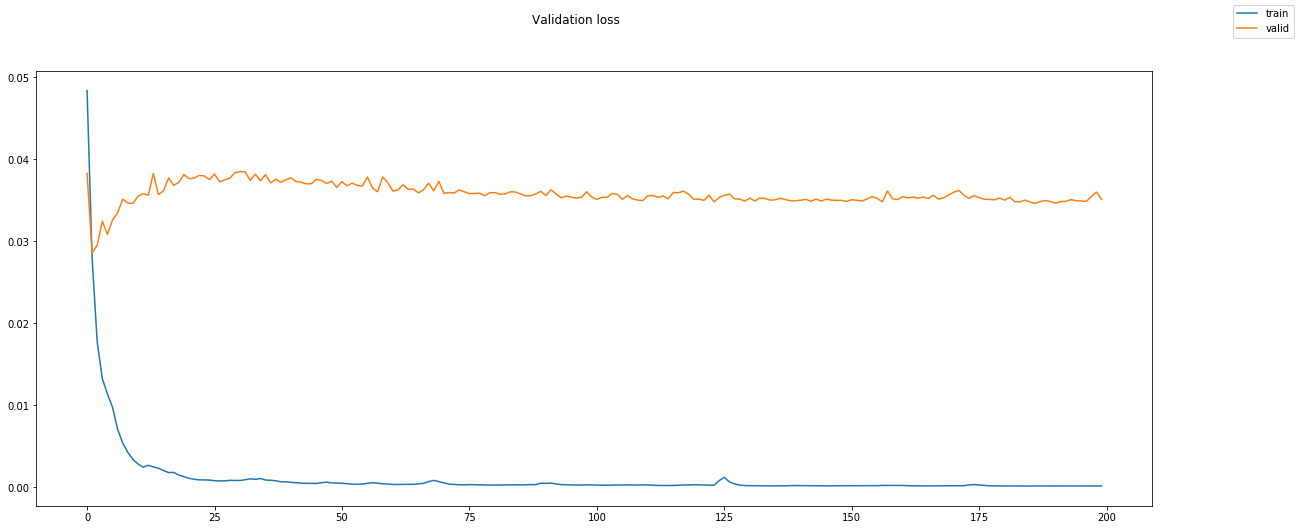

The model has 16,231,705 trainable parameters
Epoch: 1  . T, V acc: 16.4%, 23.7%. Took: 4.88s
Epoch: 2  . T, V acc: 27.7%, 25.8%. Took: 4.80s
Epoch: 3  . T, V acc: 29.4%, 26.6%. Took: 4.81s
Epoch: 4  . T, V acc: 34.0%, 21.6%. Took: 4.93s
Epoch: 5  . T, V acc: 36.3%, 22.5%. Took: 4.83s
Epoch: 6  . T, V acc: 41.2%, 22.6%. Took: 4.77s
Epoch: 7  . T, V acc: 48.3%, 22.5%. Took: 4.90s
Epoch: 8  . T, V acc: 52.8%, 23.0%. Took: 4.88s
Epoch: 9  . T, V acc: 56.4%, 22.8%. Took: 4.83s
Epoch: 10 . T, V acc: 46.6%, 22.7%. Took: 4.80s
Epoch: 11 . T, V acc: 53.3%, 20.6%. Took: 4.86s
Epoch: 12 . T, V acc: 49.9%, 24.2%. Took: 5.24s
Epoch: 13 . T, V acc: 65.5%, 24.6%. Took: 4.65s
Epoch: 14 . T, V acc: 73.4%, 25.1%. Took: 4.64s
Epoch: 15 . T, V acc: 78.0%, 24.7%. Took: 4.63s
Epoch: 16 . T, V acc: 81.8%, 25.1%. Took: 4.65s
Epoch: 17 . T, V acc: 84.6%, 25.2%. Took: 4.64s
Epoch: 18 . T, V acc: 85.9%, 25.7%. Took: 4.63s
Epoch: 19 . T, V acc: 87.0%, 25.6%. Took: 4.68s
Epoch: 20 . T, V acc: 88.7%, 26.0%. Took: 

Epoch: 171. T, V acc: 99.4%, 41.2%. Took: 4.68s
Epoch: 172. T, V acc: 99.4%, 41.4%. Took: 4.68s
Epoch: 173. T, V acc: 99.6%, 40.9%. Took: 4.69s
Epoch: 174. T, V acc: 99.6%, 40.6%. Took: 4.68s
Epoch: 175. T, V acc: 99.6%, 40.3%. Took: 4.67s
Epoch: 176. T, V acc: 99.6%, 40.5%. Took: 4.69s
Epoch: 177. T, V acc: 99.5%, 41.0%. Took: 4.67s
Epoch: 178. T, V acc: 99.4%, 40.8%. Took: 4.68s
Epoch: 179. T, V acc: 99.5%, 41.2%. Took: 4.67s
Epoch: 180. T, V acc: 99.6%, 41.5%. Took: 4.65s
Epoch: 181. T, V acc: 99.6%, 41.0%. Took: 4.65s
Epoch: 182. T, V acc: 99.6%, 40.8%. Took: 4.65s
Epoch: 183. T, V acc: 99.7%, 41.5%. Took: 4.66s
Epoch: 184. T, V acc: 99.6%, 40.7%. Took: 4.67s
Epoch: 185. T, V acc: 98.3%, 41.0%. Took: 4.66s
Epoch: 186. T, V acc: 99.0%, 41.1%. Took: 4.68s
Epoch: 187. T, V acc: 99.1%, 41.0%. Took: 4.67s
Epoch: 188. T, V acc: 99.2%, 40.8%. Took: 4.67s
Epoch: 189. T, V acc: 99.4%, 41.1%. Took: 4.67s
Epoch: 190. T, V acc: 99.5%, 41.0%. Took: 4.69s
Epoch: 191. T, V acc: 99.5%, 40.7%. Took

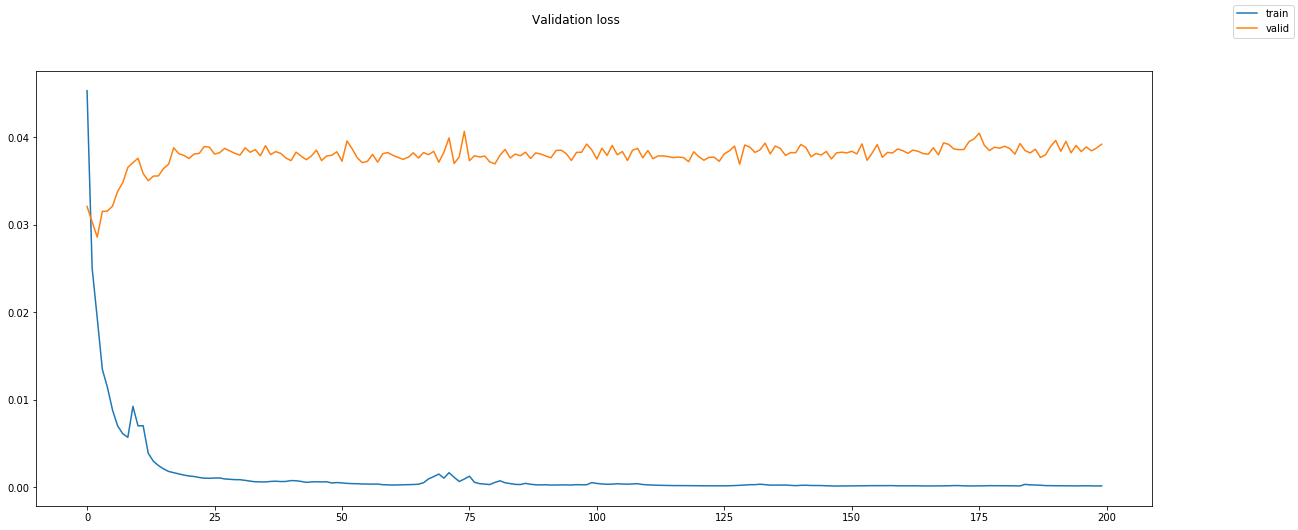

The model has 16,143,897 trainable parameters
Epoch: 1  . T, V acc: 14.3%, 17.7%. Took: 4.09s
Epoch: 2  . T, V acc: 23.6%, 23.1%. Took: 4.08s
Epoch: 3  . T, V acc: 30.3%, 23.3%. Took: 4.04s
Epoch: 4  . T, V acc: 33.8%, 24.6%. Took: 4.07s
Epoch: 5  . T, V acc: 38.8%, 21.5%. Took: 4.05s
Epoch: 6  . T, V acc: 45.9%, 20.5%. Took: 4.09s
Epoch: 7  . T, V acc: 50.1%, 20.1%. Took: 4.03s
Epoch: 8  . T, V acc: 43.1%, 20.3%. Took: 4.08s
Epoch: 9  . T, V acc: 50.7%, 21.1%. Took: 4.07s
Epoch: 10 . T, V acc: 57.3%, 20.9%. Took: 4.06s
Epoch: 11 . T, V acc: 65.4%, 20.9%. Took: 4.08s
Epoch: 12 . T, V acc: 69.4%, 20.8%. Took: 4.06s
Epoch: 13 . T, V acc: 65.7%, 21.0%. Took: 4.05s
Epoch: 14 . T, V acc: 70.0%, 21.1%. Took: 4.08s
Epoch: 15 . T, V acc: 71.0%, 21.2%. Took: 4.08s
Epoch: 16 . T, V acc: 69.8%, 21.3%. Took: 4.08s
Epoch: 17 . T, V acc: 76.4%, 21.4%. Took: 4.04s
Epoch: 18 . T, V acc: 82.0%, 21.5%. Took: 4.12s
Epoch: 19 . T, V acc: 85.3%, 21.7%. Took: 4.09s
Epoch: 20 . T, V acc: 86.0%, 21.7%. Took: 

Epoch: 171. T, V acc: 99.8%, 26.5%. Took: 4.05s
Epoch: 172. T, V acc: 99.9%, 26.1%. Took: 4.59s
Epoch: 173. T, V acc: 99.9%, 26.4%. Took: 4.11s
Epoch: 174. T, V acc: 99.9%, 26.8%. Took: 4.11s
Epoch: 175. T, V acc: 99.8%, 26.3%. Took: 4.13s
Epoch: 176. T, V acc: 99.8%, 26.6%. Took: 4.17s
Epoch: 177. T, V acc: 99.8%, 26.3%. Took: 4.25s
Epoch: 178. T, V acc: 99.8%, 26.6%. Took: 4.26s
Epoch: 179. T, V acc: 99.7%, 26.6%. Took: 4.13s
Epoch: 180. T, V acc: 99.6%, 26.7%. Took: 4.11s
Epoch: 181. T, V acc: 99.8%, 26.5%. Took: 4.16s
Epoch: 182. T, V acc: 99.8%, 26.5%. Took: 4.13s
Epoch: 183. T, V acc: 99.7%, 26.2%. Took: 4.17s
Epoch: 184. T, V acc: 99.7%, 26.3%. Took: 4.19s
Epoch: 185. T, V acc: 99.7%, 25.9%. Took: 4.15s
Epoch: 186. T, V acc: 99.7%, 26.8%. Took: 4.21s
Epoch: 187. T, V acc: 99.7%, 26.2%. Took: 4.06s
Epoch: 188. T, V acc: 99.8%, 26.8%. Took: 4.04s
Epoch: 189. T, V acc: 99.8%, 26.4%. Took: 4.06s
Epoch: 190. T, V acc: 99.8%, 26.1%. Took: 4.08s
Epoch: 191. T, V acc: 99.8%, 26.7%. Took

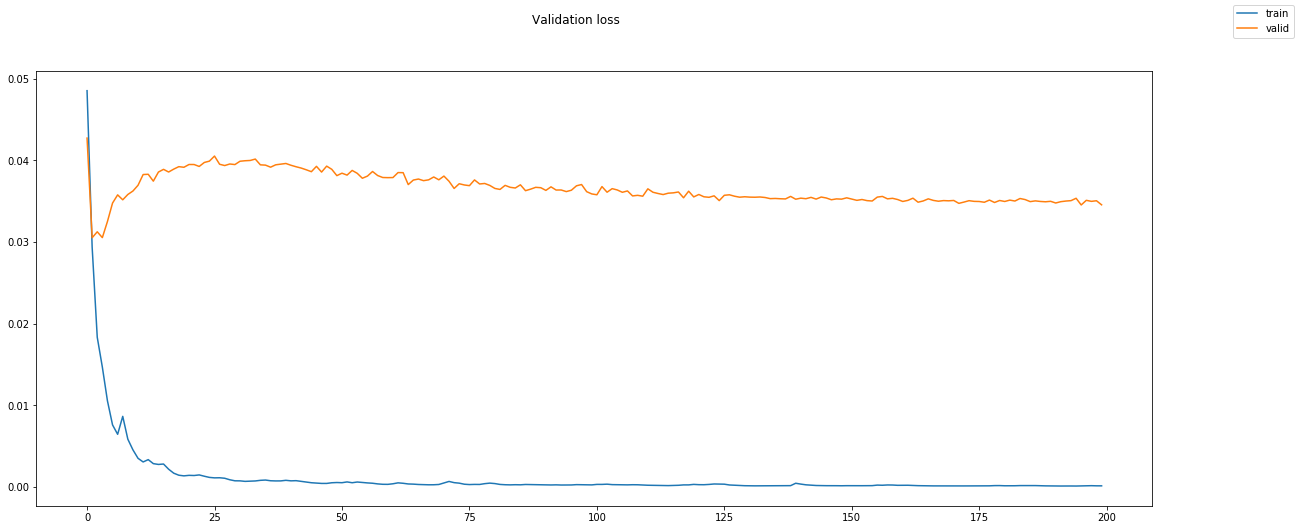

The model has 17,720,857 trainable parameters
Epoch: 1  . T, V acc: 15.3%, 24.4%. Took: 7.26s
Epoch: 2  . T, V acc: 26.2%, 26.1%. Took: 7.23s
Epoch: 3  . T, V acc: 31.1%, 23.9%. Took: 7.17s
Epoch: 4  . T, V acc: 34.8%, 22.9%. Took: 7.24s
Epoch: 5  . T, V acc: 40.2%, 22.8%. Took: 7.22s
Epoch: 6  . T, V acc: 42.8%, 22.3%. Took: 7.14s
Epoch: 7  . T, V acc: 44.7%, 21.5%. Took: 7.25s
Epoch: 8  . T, V acc: 49.3%, 22.2%. Took: 7.25s
Epoch: 9  . T, V acc: 59.5%, 22.1%. Took: 7.21s
Epoch: 10 . T, V acc: 66.1%, 22.4%. Took: 7.26s
Epoch: 11 . T, V acc: 68.3%, 22.3%. Took: 7.29s
Epoch: 12 . T, V acc: 71.8%, 22.0%. Took: 7.27s
Epoch: 13 . T, V acc: 75.6%, 22.1%. Took: 7.26s
Epoch: 14 . T, V acc: 77.5%, 22.7%. Took: 7.25s
Epoch: 15 . T, V acc: 78.2%, 22.1%. Took: 7.28s
Epoch: 16 . T, V acc: 79.2%, 22.9%. Took: 7.22s
Epoch: 17 . T, V acc: 80.7%, 22.4%. Took: 7.22s
Epoch: 18 . T, V acc: 83.3%, 22.6%. Took: 7.26s
Epoch: 19 . T, V acc: 88.0%, 22.8%. Took: 7.19s
Epoch: 20 . T, V acc: 90.1%, 22.6%. Took: 

Epoch: 171. T, V acc: 99.8%, 30.6%. Took: 7.27s
Epoch: 172. T, V acc: 99.7%, 29.7%. Took: 7.30s
Epoch: 173. T, V acc: 99.7%, 30.0%. Took: 7.24s
Epoch: 174. T, V acc: 99.7%, 30.3%. Took: 7.20s
Epoch: 175. T, V acc: 99.7%, 30.1%. Took: 7.26s
Epoch: 176. T, V acc: 99.6%, 30.3%. Took: 7.26s
Epoch: 177. T, V acc: 99.6%, 30.2%. Took: 7.24s
Epoch: 178. T, V acc: 99.7%, 30.7%. Took: 7.23s
Epoch: 179. T, V acc: 99.7%, 30.5%. Took: 7.39s
Epoch: 180. T, V acc: 99.8%, 30.3%. Took: 7.21s
Epoch: 181. T, V acc: 99.8%, 30.9%. Took: 7.13s
Epoch: 182. T, V acc: 99.8%, 30.9%. Took: 7.14s
Epoch: 183. T, V acc: 99.9%, 31.0%. Took: 7.18s
Epoch: 184. T, V acc: 99.8%, 30.9%. Took: 7.15s
Epoch: 185. T, V acc: 99.9%, 30.7%. Took: 7.13s
Epoch: 186. T, V acc: 99.8%, 31.3%. Took: 7.16s
Epoch: 187. T, V acc: 99.8%, 30.5%. Took: 7.17s
Epoch: 188. T, V acc: 99.8%, 30.9%. Took: 7.13s
Epoch: 189. T, V acc: 99.7%, 31.0%. Took: 7.15s
Epoch: 190. T, V acc: 99.8%, 31.2%. Took: 7.16s
Epoch: 191. T, V acc: 99.8%, 31.1%. Took

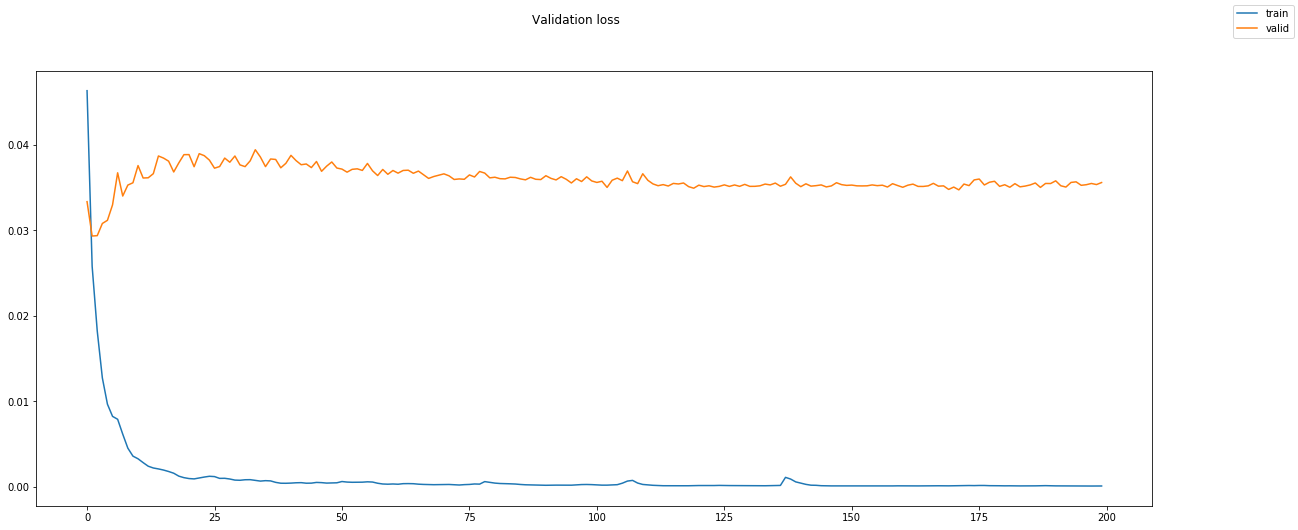

The model has 19,297,817 trainable parameters
Epoch: 1  . T, V acc: 17.4%, 23.6%. Took: 10.56s
Epoch: 2  . T, V acc: 28.3%, 25.4%. Took: 10.43s
Epoch: 3  . T, V acc: 29.3%, 26.4%. Took: 10.41s
Epoch: 4  . T, V acc: 32.8%, 22.8%. Took: 10.42s
Epoch: 5  . T, V acc: 36.5%, 23.5%. Took: 10.38s
Epoch: 6  . T, V acc: 42.0%, 22.5%. Took: 10.38s
Epoch: 7  . T, V acc: 49.9%, 23.0%. Took: 10.44s
Epoch: 8  . T, V acc: 54.6%, 20.8%. Took: 10.43s
Epoch: 9  . T, V acc: 59.7%, 22.7%. Took: 10.49s
Epoch: 10 . T, V acc: 65.0%, 22.3%. Took: 10.43s
Epoch: 11 . T, V acc: 67.1%, 23.0%. Took: 10.45s
Epoch: 12 . T, V acc: 69.1%, 22.0%. Took: 10.87s
Epoch: 13 . T, V acc: 69.7%, 22.5%. Took: 10.41s
Epoch: 14 . T, V acc: 71.9%, 22.7%. Took: 10.37s
Epoch: 15 . T, V acc: 76.0%, 22.9%. Took: 10.38s
Epoch: 16 . T, V acc: 76.4%, 23.6%. Took: 10.42s
Epoch: 17 . T, V acc: 83.8%, 23.4%. Took: 10.47s
Epoch: 18 . T, V acc: 87.3%, 23.2%. Took: 10.44s
Epoch: 19 . T, V acc: 87.7%, 23.9%. Took: 10.46s
Epoch: 20 . T, V acc: 8

Epoch: 168. T, V acc: 99.6%, 40.5%. Took: 10.48s
Epoch: 169. T, V acc: 99.6%, 40.4%. Took: 10.42s
Epoch: 170. T, V acc: 99.6%, 39.6%. Took: 10.45s
Epoch: 171. T, V acc: 99.7%, 40.4%. Took: 10.46s
Epoch: 172. T, V acc: 99.7%, 40.5%. Took: 10.46s
Epoch: 173. T, V acc: 99.1%, 40.2%. Took: 10.43s
Epoch: 174. T, V acc: 99.2%, 39.8%. Took: 10.50s
Epoch: 175. T, V acc: 99.4%, 39.6%. Took: 10.50s
Epoch: 176. T, V acc: 99.6%, 39.7%. Took: 10.44s
Epoch: 177. T, V acc: 99.6%, 40.8%. Took: 10.48s
Epoch: 178. T, V acc: 99.7%, 40.1%. Took: 10.45s
Epoch: 179. T, V acc: 99.7%, 40.3%. Took: 10.45s
Epoch: 180. T, V acc: 99.7%, 40.1%. Took: 10.42s
Epoch: 181. T, V acc: 99.8%, 40.5%. Took: 10.71s
Epoch: 182. T, V acc: 99.8%, 40.6%. Took: 10.56s
Epoch: 183. T, V acc: 99.8%, 40.9%. Took: 10.46s
Epoch: 184. T, V acc: 99.8%, 40.8%. Took: 10.46s
Epoch: 185. T, V acc: 99.8%, 40.9%. Took: 10.43s
Epoch: 186. T, V acc: 99.8%, 41.3%. Took: 10.46s
Epoch: 187. T, V acc: 99.8%, 40.9%. Took: 10.46s
Epoch: 188. T, V acc

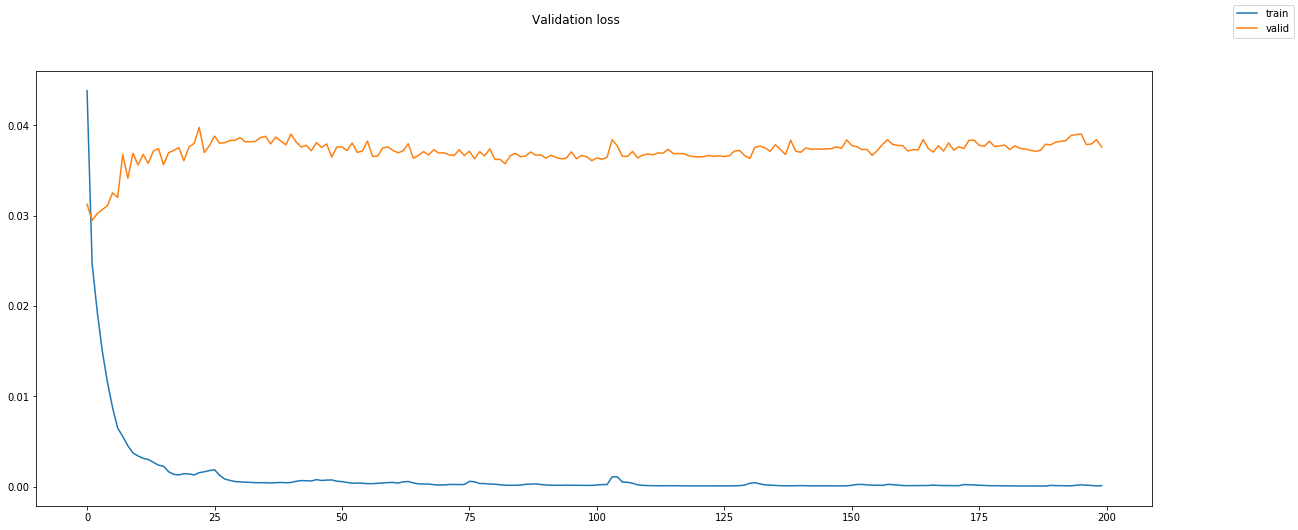

In [270]:
for train_set in train_sets:
    train_set.init()
    train_info = train_set.do_training()
    
    train_info.save(f"info_{train_set.name}.pickle")
    
    # plot loss data
    fig, ax = plt.subplots(figsize=(20, 8))
    ax_train = ax.plot(list(range(train_set.n_epochs)), train_info.train["loss"], label="train")
    ax_valid = ax.plot(list(range(train_set.n_epochs)), train_info.valid["loss"], label="valid")
    fig.legend()
    fig.suptitle("Validation loss")
    plt.show()

## Peeking

In [108]:
import spacy

nlp = spacy.load('fr_core_news_sm')

In [106]:
def predict_tokens(tokens, model):
    model.eval()
    idxs = [TEXT.vocab.stoi[t] for t in tokens]
    inp = torch.LongTensor(idxs).reshape(-1, 1).to(device)
    output = output_to_pred(model(inp, torch.LongTensor([len(tokens)])))
    return output.item()


def predict(sentence, model):
    return predict_tokens(list(map(str, nlp.tokenizer(sentence))), model)

In [104]:
model.load_state_dict(torch.load('best_model_rnn_hidden-512.pt'))

<All keys matched successfully>

In [110]:
model = model.to(DEVICE)

In [112]:
predict("Du temps perdu.", model), \
predict("Un très bon film, à voir avec toute la famille.", model)

(2.5, 4.0)

In [113]:
for example in random.sample(list(data_test), 3):
    tokens, note = example.critique, float(example.note)
    print(" ".join(tokens))
    print(f"true) {note} - {predict_tokens(tokens, model)} (pred")

Bouleversant , parfois dérangeant . Inoubliable , en tout cas .
true) 4.0 - 4.0 (pred
On attendait ce volume 3 avec impatience et on n' est pas déçu . Les petits se gondolent , les plus grands aussi .
true) 3.0 - 3.5 (pred
Malgré un scénario faiblard et une longueur éprouvante , " Transformers 4 : L' Âge de l' extinction " ne s' en sort pas trop mal grâce au renouveau du casting , l' introduction des Dinobots , et l' ahurissante mise en scène du maître artificier Michael Bay .
true) 3.0 - 1.5 (pred


## Testing predictions on extremal marks

Is the model really doing bad if it predicts a 4.5 instead of a 5 ? There are at least two ways to allow for forgivable divergence with the test data :
* decrease notation's granularity, e.g. tranform the marks into good/bad, or good/bad/neutral.
* consider a prediction correct if it belongs to a 'small' interval containing the true value.

### Good/Neutral/Bad prediction

In [114]:
def mark_to_3_way(mark_tensor, bad_treshold=2, good_treshold=3.5):
    """np array with values: 0: bad, 1: neutral, 2: good"""
    return np.digitize(mark_tensor.cpu().detach().numpy(), [bad_treshold, good_treshold])

def pred_to_3_way(pred_tensor, bad_treshold=0.4, good_treshold=0.651):
    """np array with values: 0: bad, 1: neutral, 2: good"""
    return np.digitize(pred_tensor.cpu().detach().numpy(), [bad_treshold, good_treshold])
    
def eval_accuracy_3w(model, iterator):
    n_examples = 0
    n_success = 0
    for batch in iterator:
        padded_sequences, lengths = batch.critique
        predictions = model(padded_sequences, lengths).squeeze(1)
        n_examples += len(batch)
        n_success += sum(pred_to_3_way(predictions) == mark_to_3_way(batch.note))
    return n_success / n_examples

def classif_report_3w(model, iterator):
    def preds_and_trues_to_array(predictions, true_notes):
        return np.concatenate([mark_to_3_way(true_notes).reshape(-1, 1),
                               pred_to_3_way(predictions).reshape(-1, 1)], axis=1)
    
    array = None
    for batch in iterator:
        padded_sequences, lengths = batch.critique
        predictions = model(padded_sequences, lengths).squeeze(1)
        
        if array is None:
            array = preds_and_trues_to_array(predictions, batch.note)
        else:
            array = np.concatenate([array,
                                    preds_and_trues_to_array(predictions, batch.note)], axis=0)
    print(sklearn.metrics.classification_report(array[:, 0],
                                                array[:, 1],
                                                labels=[0, 1, 2],
                                                target_names=["bad", "neutral", "good"]))

In [115]:
iterator = iter_test

classif_report_3w(model, iterator)


              precision    recall  f1-score   support

         bad       0.30      0.48      0.37      1688
     neutral       0.65      0.48      0.55      9696
        good       0.72      0.82      0.77     10692

    accuracy                           0.65     22076
   macro avg       0.56      0.59      0.56     22076
weighted avg       0.66      0.65      0.64     22076



### Fuzzy accuracy

In [116]:
def eval_accuracy_fuzzy(model, iterator, fuzziness=.5):
    n_examples = 0.
    n_success = 0.
    for batch in iterator:
        padded_sequences, lengths = batch.critique
        predictions = model(padded_sequences, lengths).squeeze(1)
        n_examples += len(batch)
        n_success += sum(torch.abs(output_to_pred(predictions) - batch.note) <= fuzziness).item()
    return n_success / n_examples

In [188]:
eval_accuracy_fuzzy(model, iter_test, fuzziness=.5)